In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), ".."))
main_dir = os.path.abspath('..')
os.chdir(main_dir)
sys.path.append(main_dir)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PhysicsRegression import PhyReg
import copy

### Step1: Load contribution function data

In [2]:
x_to_fit = []
y_to_fit = []

df = pd.read_csv("./data/physics_data/Fe X     175.263    2 -   31 3s2 3p5 2P0.5 - 3s2 3p4 3d 2D1.5.csv")

temperature =   np.array(list(df["temperature"])).  reshape((-1, 1)) / 1e6
edensity =      np.array(list(df["eDensity"])).     reshape((-1, 1)) / 1e10
gofnt =         np.array(list(df["gofnt"])).        reshape((-1, 1)) / 1e-25

x = np.concatenate([temperature, edensity], axis=1)

x_to_fit.append(x)
y_to_fit.append(gofnt)

x_train, x_test, y_train, y_test = train_test_split(x_to_fit[0], y_to_fit[0], test_size=0.15, random_state=2024)
x_to_fit[0] = x_train
y_to_fit[0] = y_train

### Step2: Inference with PhyReg

In [3]:
np.random.seed(2024)

phyreg = PhyReg(
    path = "./model.pt",
    max_len=10000,
)

phyreg.fit(
    x_to_fit, y_to_fit, 
    use_Divide=True, 
    use_MCTS=False, 
    use_GP=False, 
    use_pysr_init=True, 
    use_const_optimization=False,
    verbose=False,
    oracle_name="physical4",
    oracle_file="./physical/data/oracle_model_case4/",
    oracle_bs=64, oracle_lr=0.006, oracle_epoch=1000,
    use_seperate_type=["id"],
    fixed_x_range=[0.8, 1.5],
    save_oracle_model=True
)

In [4]:
phyreg.best_gens_bfgs[2]["predicted_tree"]

((-0.293063458500073 mul inv((x_0 add 0.25229193813423284))) add 1.2994567521039824)

In [5]:
phyreg.express_best_gens(phyreg.best_gens, use_sp=True)

idx : 0
expr: 2.38405866725699*x_0**2*(0.0118776377896631*x_1 + 1.0)**2*exp(-0.8968987527740477*x_0**2) - 0.133101913737604
mse : 0.07405491329528961



Next, we aim to optimize the constants, several modifications are made as follows:

- A log-scale is applied in the optimization process.

- The 'eDensity' term in the formula is replaced by the result from the oracle model.

- The two 'power' constants are treated as free constants and optimized simultaneously.

- Two additional free parameters are introduced for the 'temperature' variable to allow greater flexibility.

- Fixed scale constants are multiplied to ensure the optimization process proceeds correctly.

In [ ]:
np.random.seed(2024)

best_gens = phyreg.best_gens
best_gens[0]["predicted_tree"] = "log(200*((-0.293063458500073 /((x_1 + 0.25229193813423284))) + 1.2994567521039824) * 10000*2.38405866725699*(x_0 - 0.0)** -20.0 *exp(-0.8968987527740477*(x_0 - 0.0)** -2.0 ))"

phyreg.params.num_bfgs = 6000
best_gens = phyreg.constant_optimization(best_gens, x_to_fit, [np.log(y_to_fit[0])], sigma=0.1)
phyreg.express_skeleton(best_gens, use_sp=True)
phyreg.express_best_gens(best_gens)

idx          : 0
expr skeleton: log(C_0*(C_1 - C_2/(x_1 + C_3))*exp(C_4/(x_0 + C_5)**C_6)/(x_0 - C_7)**C_8)
constants    : 260003.683 29.201 13.876 0.809 -35.652 0.272 1.753 0.314 22.023

idx : 0
expr: log(260003.6830962341*(29.20075389899055 - 13.87596608242056/(x_1 + 0.8093545090589316))*exp(-35.65209487461984/(x_0 + 0.27176825338346017)**1.7534561894272354)/(x_0 - 0.313873914775877)**22.023410133582797)
mse : 0.07405491329528961



### Step3: plot the predicted formula

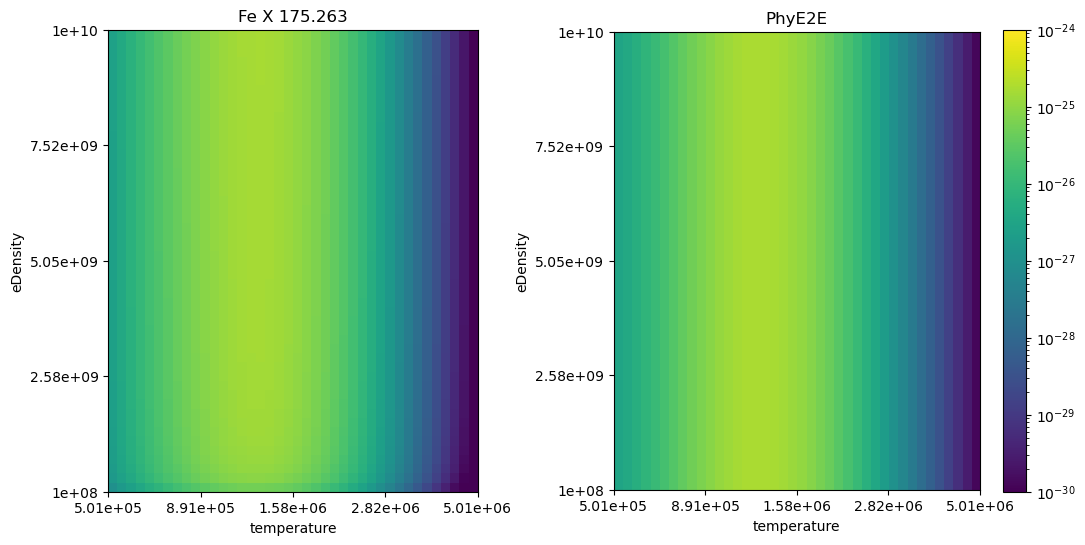

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

norm = mcolors.LogNorm(vmin=1e-30, vmax=1e-24)

from numpy import exp, log

x_0 = temperature
x_1 = edensity
pred = 260003.6830962341*(29.20075389899055 - 13.87596608242056/(x_1 + 0.8093545090589316))*exp(-35.65209487461984/(x_0 + 0.27176825338346017)**1.7534561894272354)/(x_0 - 0.313873914775877)**22.023410133582797

plt.figure(figsize=(13, 6))

plt.subplot(1, 2, 1)
plt.imshow((gofnt.reshape((50, 50)))[::-1, :40] * 1e-25, norm = norm, aspect="equal")
plt.title("Fe X 175.263")
#plt.colorbar()
plt.xlabel("temperature")
plt.ylabel("eDensity")
plt.xticks(np.linspace(0, 40, 5)-0.5, [f"{a:.3g}" for a in 10.**(5.7 + 0.05*np.linspace(0, 20, 5))])
plt.yticks(np.linspace(0, 50, 5)-0.5, [f"{a:.3g}" for a in np.linspace(1e8, 1e10, 5)][::-1])

plt.subplot(1, 2, 2)
plt.imshow((pred.reshape((50, 50)))[::-1, :40] * 1e-25, norm = norm, aspect="equal")
plt.title("PhyE2E")
plt.colorbar()
plt.xlabel("temperature")
plt.ylabel("eDensity")
plt.xticks(np.linspace(0, 40, 5)-0.5, [f"{a:.3g}" for a in 10.**(5.7 + 0.05*np.linspace(0, 20, 5))])
plt.yticks(np.linspace(0, 50, 5)-0.5, [f"{a:.3g}" for a in np.linspace(1e8, 1e10, 5)][::-1])

plt.show()